In [ ]:
!pip install gym[toy_text] > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import gym
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import pyvirtualdisplay

In [ ]:
env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=False)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print('Class name: {}'.format(env.class_name))
print('Action space: {}'.format(env.action_space))
print('Observation space: {}'.format(env.observation_space))
print('Reward range: {}'.format(env.reward_range))
print('Env spec: {}'.format(env.spec))

Class name: <bound method Wrapper.class_name of <class 'gym.wrappers.time_limit.TimeLimit'>>
Action space: Discrete(4)
Observation space: Discrete(16)
Reward range: (0, 1)
Env spec: EnvSpec(id='FrozenLake-v1', entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={'map_name': '4x4', 'is_slippery': False}, namespace=None, name='FrozenLake', version=1)


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


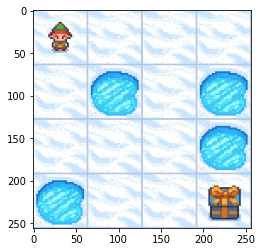

In [ ]:
env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [ ]:
env.render(mode='rgb_array').shape

(256, 256, 3)

In [ ]:
from copy import deepcopy
from tqdm import tqdm

field_size = 16 #4x4

def argmax(lst):
  max = 0
  pos = 0
  for i in range(len(lst)):
    if lst[i] > max:
      max = lst[i]
      pos = i
  return pos

def test_convergence(env,Q,epsilon,iteration):
  state = env.reset()
  terminated = 0
  while not terminated:
    action = get_action(state,Q) #greedy action
    state, reward, terminated, info = env.step(action)
  return reward #no need to calculate sum of rewards, since the only reward different than 0 is +1 at the end of the game in case of win

def initialize():
  num_returns = []
  Q = []
  for i in range(field_size):
    lst1 = [0,0,0,0] 
    lst2 = [1,1,1,1]
    num_returns.append(lst1)
    Q.append(lst2) #starting with max possible reward to improve exploration

  cumulative_wins = []
  return num_returns,cumulative_wins,Q

def get_action(state,Q,epsilon=None,iteration=None): #takes into consideration, also, the possibility to initially collect some episodes without updating Q. The collect steps would be random
  def get_action_epsilon(state,Q,epsilon=0): #epsilon-greedy
    if np.random.randint(10) >= epsilon:
      action = argmax(Q[state])
    else:
      action = np.random.randint(4)
    return action

  if epsilon != None and iteration != None:
    if iteration < COLLECT_EPISODES:
      action = np.random.randint(4) #random action due to random collect episodes
    else:
      action = get_action_epsilon(state,Q,epsilon) #epsilon greedy
  else:
    action = get_action_epsilon(state,Q) #greedy action
  return action

def train(env,mode='e-greedy'):
  num_returns,cumulative_wins,Q = initialize()

  #training loop
  for i in tqdm(range(EPISODES)):
    if i >= COLLECT_EPISODES and mode == 'e-greedy':
      epsilon = max(1/((i-COLLECT_EPISODES)/5+1),0.1)*10 #decreasing epsilon
    else:
      epsilon = 10 #random
    state = env.reset()

    terminated = 0
    state_action_pairs = []
    while not terminated:
      action = get_action(state,Q,epsilon,i)
      state_action_pairs.append((state,action))
      state, reward, terminated, info = env.step(action)

    for s,a in state_action_pairs:
      num_returns[s][a] += 1
      Q[s][a] += (reward-Q[s][a]) / num_returns[s][a]

    #test policy
    #reward_greedy = test_convergence(env,Q,epsilon,i)

    if len(cumulative_wins) == 0:
      cumulative_wins.append(reward)
    else:
      cumulative_wins.append(cumulative_wins[-1]+reward)
  return Q, cumulative_wins

EPISODES = 500
COLLECT_EPISODES = 200

In [ ]:
Q_montecarlo, cumulative_wins_montecarlo = train(env,'random')
cumulative_wins_montecarlo[-1]

100%|██████████| 500/500 [00:00<00:00, 4217.07it/s]


14.0

In [ ]:
Q_montecarlo_epsilon, cumulative_wins_montecarlo_epsilon = train(env,'e-greedy')
cumulative_wins_montecarlo_epsilon[-1]

100%|██████████| 500/500 [00:00<00:00, 5816.15it/s]


261.0

In [ ]:
def train_sarsa(env,alpha=0.2,gamma=0.2):
  _,cumulative_wins,Q = initialize()
  for i in tqdm(range(EPISODES)):
    if i >= COLLECT_EPISODES:
      epsilon = max(1/((i-COLLECT_EPISODES)/5+1),0.1)*10 #decreasing epsilon
    else:
      epsilon = 10
    state = env.reset()
    terminated = 0

    action = get_action(state,Q,epsilon,i)
    while not terminated:
      state_next, reward, terminated, info = env.step(action)
      action_next = get_action(state_next,Q,epsilon,i)

      Q[state][action] += alpha*(reward+gamma*Q[state_next][action_next]-Q[state][action])
      state = state_next
      action = action_next
    Q[state][action] = 0

    #test policy
    #reward = test_convergence(env,Q,epsilon,i)

    if len(cumulative_wins) == 0:
      cumulative_wins.append(reward)
    else:
      cumulative_wins.append(cumulative_wins[-1]+reward)
  return Q, cumulative_wins

In [ ]:
Q_sarsa, cumulative_wins_sarsa = train_sarsa(env)
cumulative_wins_sarsa[-1]

100%|██████████| 500/500 [00:00<00:00, 5672.12it/s]


232.0

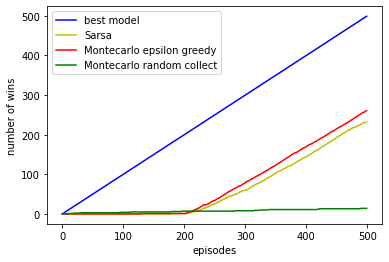

In [ ]:
#plotting

best = np.arange(EPISODES)
plt.plot(best,best,'-b',label='best model')
plt.plot(best,cumulative_wins_sarsa,'-y',label='Sarsa')
plt.plot(best,cumulative_wins_montecarlo_epsilon,'-r',label='Montecarlo epsilon greedy')
plt.plot(best,cumulative_wins_montecarlo,'-g',label='Montecarlo random collect')
plt.xlabel('episodes')
plt.ylabel('number of wins')
plt.legend()
plt.show()

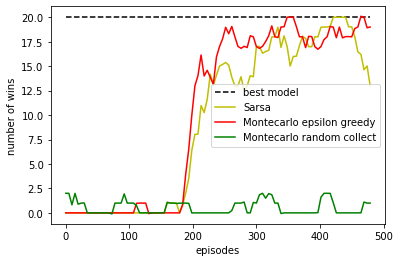

In [ ]:
from scipy.interpolate import make_interp_spline

def avg_for_plot(returns):
  averages = []
  for i in range(20,len(returns)):
    averages.append(returns[i]-returns[i-20])
  return averages

avg_wins_sarsa = avg_for_plot(cumulative_wins_sarsa)
avg_wins_montecarlo_epsilon = avg_for_plot(cumulative_wins_montecarlo_epsilon)
avg_wins_montecarlo = avg_for_plot(cumulative_wins_montecarlo)

best = np.ones(len(avg_wins_sarsa))*20
x = np.arange(EPISODES)[20:]-20

xnew = np.linspace(min(x), max(x), 100)

spl1 = make_interp_spline(x, avg_wins_sarsa, k=3)
spl2 = make_interp_spline(x, avg_wins_montecarlo_epsilon, k=3)
spl3 = make_interp_spline(x, avg_wins_montecarlo, k=3)

smooth_sarsa = spl1(xnew)
smooth_montecarlo_epsilon = spl2(xnew)
smooth_montecarlo = spl3(xnew)


plt.plot(x,best,linestyle='dashed',color='black',label='best model')
plt.plot(xnew,smooth_sarsa,'-y',label='Sarsa')
plt.plot(xnew,smooth_montecarlo_epsilon,'-r',label='Montecarlo epsilon greedy')
plt.plot(xnew,smooth_montecarlo,'-g',label='Montecarlo random collect')
plt.xlabel('episodes')
plt.ylabel('number of wins')
plt.legend()
plt.show()

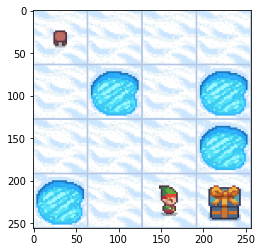

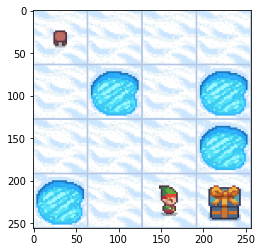

In [ ]:
#show behaviour of model

def show(env):
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

TEST_EP = 5

for i in range(TEST_EP):
  state = env.reset()
  terminated = 0
  while not terminated:
    show(env)
    action = get_action(state,Q_montecarlo_epsilon)
    state, reward, terminated, info = env.step(action)

# Curiosity-driven learning

In [ ]:
import tensorflow as tf
from tensorflow import keras

class FeatureEmbeddingModel(keras.Model):
  def __init__(self):
    super(FeatureEmbeddingModel,self).__init__()
    self.sequential = keras.Sequential([
        keras.layers.Conv2D(8,5,activation='relu'),
        keras.layers.Conv2D(8,3,strides=2,activation='relu'),
        keras.layers.Conv2D(16,3,activation='relu'),
        keras.layers.Conv2D(16,3,strides=2,activation='relu'),
        keras.layers.Conv2D(32,3)
    ])

  def call(self,input):
    return self.sequential(input)

class Predictor(keras.Model):
  def __init__(self):
    super(Predictor,self).__init__()
    self.sequential = keras.Sequential([
        keras.layers.Conv2D(8,5,activation='relu'),
        keras.layers.Conv2D(8,3,strides=2,activation='relu'),
        keras.layers.Conv2D(16,3,activation='relu'),
        keras.layers.Conv2D(16,3,strides=2,activation='relu'),
        keras.layers.Conv2D(32,3,bias_initializer="zeros")
    ])
    self.relu = keras.layers.ReLU()
    self.final_conv = keras.layers.Conv2D(32,3,padding='same')

    self.errors = [] #used for plotting loss

  def call(self,input):
    state = tf.cast(input[0],dtype=tf.float32)
    action_value = tf.cast(input[1],dtype=tf.float32)

    state_embedded = self.sequential(state)

    #add scalar action value to embedding

    action_matrix = np.ones(state_embedded.shape)*action_value
    state_action_embedded = self.relu(keras.layers.Add()([state_embedded,action_matrix]))

    next_state_representation = self.final_conv(state_action_embedded)
    return next_state_representation

  def add_error(self,value):
    self.errors.append(value)

  def plot_error(self):
    x = np.arange(len(self.errors))
    plt.plot(x[:-50],self.errors[50:],'-b',label='Prediction loss') #50 is to avoid plotting the initial part of learning, due to the high initial prediction error

    plt.xlabel('steps')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

def mse(a, b):
  a = np.array(a)
  b = np.array(b)

  if a.shape != b.shape:
    raise ValueError("Input arrays must have the same shape")

  mean_squared_error = np.mean((a - b) ** 2)
  return mean_squared_error


def get_curiosity(predictor, embedding_model, state, action, next_state, dataset=None):
  state = np.expand_dims(state,axis=0)
  next_state = np.expand_dims(next_state,axis=0)

  state_embedded = embedding_model(state)
  next_state_embedded = embedding_model(next_state)
  prediction = predictor([state,action])

  curiosity = mse(next_state_embedded,prediction)
  predictor.add_error(curiosity)

  if dataset is not None:
    if len(dataset) > 0:
      dataset = np.vstack([dataset,[state,action,next_state_embedded.numpy()]])
    else:
      dataset = np.array([state,action,next_state_embedded.numpy()])
    return curiosity,dataset
  return curiosity

In [ ]:
def train_sarsa_curiosity(env,predictor,embedding_model,alpha=0.2,gamma=0.8):
  _,cumulative_wins,Q = initialize()
  num_steps = 0

  for i in tqdm(range(EPISODES)):
    if i >= COLLECT_EPISODES:
      epsilon = max(1/((i-COLLECT_EPISODES)/5+1),0.1)*10 #decreasing epsilon
    else:
      epsilon = 10

    state = env.reset()
    state_img = env.render(mode='rgb_array')
    terminated = 0

    action = get_action(state,Q,epsilon,i)

    while not terminated:
      if num_steps % fit_info['batch_size'] == 0:
        if num_steps != 0:
          predictor.fit([np.stack(dataset[:,0]).astype(np.float32),dataset[:,1].astype(np.float32)],np.stack(dataset[:,2]),**fit_info)
        dataset = np.array([])
      num_steps+=1

      state_next, reward, terminated, info = env.step(action) #extrinsic reward
      state_next_img = env.render(mode='rgb_array')

      action_next = get_action(state_next,Q,epsilon,i)

      curiosity_reward,dataset = get_curiosity(predictor,embedding_model,state_img,action,state_next_img,dataset) #intrinsic reward

      Q[state][action] += alpha*(curiosity_reward+gamma*Q[state_next][action_next]-Q[state][action])

      state = state_next
      action = action_next
    Q[state][action] = 0

    #test policy
    #reward = test_convergence(env,Q,epsilon,i)

    if len(cumulative_wins) == 0:
      cumulative_wins.append(reward)
    else:
      cumulative_wins.append(cumulative_wins[-1]+reward)
  return Q, cumulative_wins

In [ ]:
embedding_model = FeatureEmbeddingModel()
predictor = Predictor()

compile_info = {
    'optimizer': keras.optimizers.Adam(),
    'loss': keras.losses.MeanSquaredError(),
}

fit_info = {
    'verbose': 0,
    'epochs': 1,
    'batch_size': 32
}

predictor.compile(**compile_info)

embedding_model.trainable = False

embedding_model.build(input_shape=(None,256,256,3))
#embedding_model.summary()

In [ ]:
Q_sarsa_curiosity, cumulative_wins_sarsa_curiosity = train_sarsa_curiosity(env,predictor,embedding_model)
cumulative_wins_sarsa_curiosity[-1]

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<ipython-input-71-d9c0237a0ed6>:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array([state,action,next_state_embedded.numpy()])
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

4.0

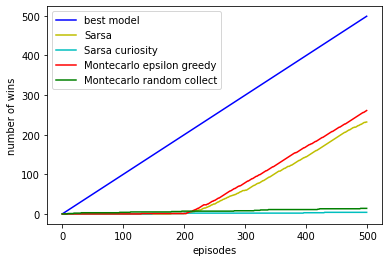

In [ ]:
#plotting

best = np.arange(EPISODES)
plt.plot(best,best,'-b',label='best model')
plt.plot(best,cumulative_wins_sarsa,'-y',label='Sarsa')
plt.plot(best,cumulative_wins_sarsa_curiosity,'-c',label='Sarsa curiosity')
plt.plot(best,cumulative_wins_montecarlo_epsilon,'-r',label='Montecarlo epsilon greedy')
plt.plot(best,cumulative_wins_montecarlo,'-g',label='Montecarlo random collect')

plt.xlabel('episodes')
plt.ylabel('number of wins')
plt.legend()
plt.show()

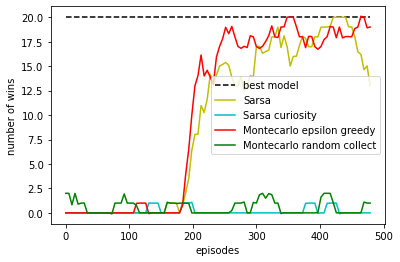

In [ ]:
avg_wins_curiosity = avg_for_plot(cumulative_wins_sarsa_curiosity)

best = np.ones(len(avg_wins_sarsa))*20
x = np.arange(EPISODES)[20:]-20

spl4 = make_interp_spline(x, avg_wins_curiosity, k=3)

smooth_curiosity = spl4(xnew)

plt.plot(x,best,linestyle='dashed',color='black',label='best model')
plt.plot(xnew,smooth_sarsa,'-y',label='Sarsa')
plt.plot(xnew,smooth_curiosity,'-c',label='Sarsa curiosity')
plt.plot(xnew,smooth_montecarlo_epsilon,'-r',label='Montecarlo epsilon greedy')
plt.plot(xnew,smooth_montecarlo,'-g',label='Montecarlo random collect')
plt.xlabel('episodes')
plt.ylabel('number of wins')
plt.legend()
plt.show()

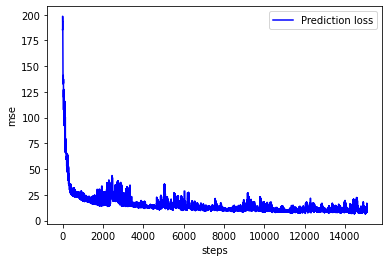

In [ ]:
predictor.plot_error()

In [ ]:
import random

def salt_pepper(img,prob=.1):
  for i in range(len(img)):
    for j in range(len(img[i])):
      for k in range(len(img[i][j])):
        if random.uniform(0,1) >= prob:
          continue
        if random.randint(0,1):
          img[i][j][k] = 255
        else:
          img[i][j][k] = 0
  return img

def train_sarsa_curiosity_with_noise(env,predictor,embedding_model,alpha=0.2,gamma=0.8):
  _,cumulative_wins,Q = initialize()
  num_steps = 0

  for i in tqdm(range(EPISODES)):
    if i >= COLLECT_EPISODES:
      epsilon = max(1/(i-COLLECT_EPISODES+1),0.1)*10 #decreasing epsilon
    else:
      epsilon = 10

    state = env.reset()
    state_img = env.render(mode='rgb_array')
    terminated = 0

    action = get_action(state,Q,epsilon,i)

    while not terminated:
      if num_steps % fit_info['batch_size'] == 0:
        if num_steps != 0:
          predictor.fit([np.stack(dataset[:,0]).astype(np.float32),dataset[:,1].astype(np.float32)],np.stack(dataset[:,2]),**fit_info)
        dataset = np.array([])
      num_steps+=1

      state_next, reward, terminated, info = env.step(action) #extrinsic reward
      state_next_img = env.render(mode='rgb_array')

      action_next = get_action(state_next,Q,epsilon,i)

      if terminated and i>50 and reward == 1:
        state_next_img = salt_pepper(state_next_img,1-(1/(i+1)))
      curiosity_reward,dataset = get_curiosity(predictor,embedding_model,state_img,action,state_next_img,dataset) #intrinsic reward

      if i<50:
        curiosity_reward /= 100

      if terminated and reward == 1:
        curiosity_reward *= 100

      Q[state][action] += alpha*(curiosity_reward+gamma*Q[state_next][action_next]-Q[state][action])

      state = state_next
      action = action_next
    Q[state][action] = 0

    #test policy
    #reward = test_convergence(env,Q,epsilon,i)

    if len(cumulative_wins) == 0:
      cumulative_wins.append(reward)
    else:
      cumulative_wins.append(cumulative_wins[-1]+reward)
  return Q, cumulative_wins

In [ ]:
embedding_model = FeatureEmbeddingModel()
predictor = Predictor()

compile_info = {
    'optimizer': keras.optimizers.Adam(),
    'loss': keras.losses.MeanSquaredError(),
}

fit_info = {
    'verbose': 0,
    'epochs': 1,
    'batch_size': 32
}

predictor.compile(**compile_info)

embedding_model.trainable = False

embedding_model.build(input_shape=(None,256,256,3))

In [ ]:
Q_sarsa_curiosity, cumulative_wins_sarsa_curiosity = train_sarsa_curiosity_with_noise(env,predictor,embedding_model)
cumulative_wins_sarsa_curiosity[-1]

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
<ipython-input-71-d9c0237a0ed6>:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array([state,action,next_state_embedded.numpy()])
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

183.0

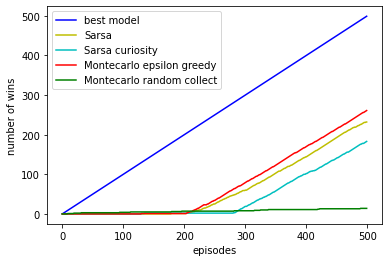

In [ ]:
#plotting

best = np.arange(EPISODES)
plt.plot(best,best,'-b',label='best model')
plt.plot(best,cumulative_wins_sarsa,'-y',label='Sarsa')
plt.plot(best,cumulative_wins_sarsa_curiosity,'-c',label='Sarsa curiosity')
plt.plot(best,cumulative_wins_montecarlo_epsilon,'-r',label='Montecarlo epsilon greedy')
plt.plot(best,cumulative_wins_montecarlo,'-g',label='Montecarlo random collect')

plt.xlabel('episodes')
plt.ylabel('number of wins')
plt.legend()
plt.show()

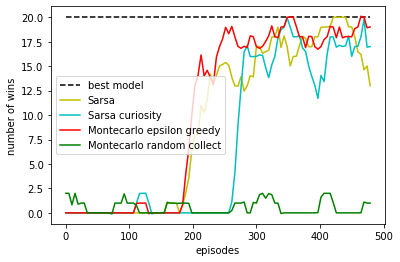

In [ ]:
avg_wins_curiosity = avg_for_plot(cumulative_wins_sarsa_curiosity)

best = np.ones(len(avg_wins_sarsa))*20
x = np.arange(EPISODES)[20:]-20

spl4 = make_interp_spline(x, avg_wins_curiosity, k=3)

smooth_curiosity = spl4(xnew)

plt.plot(x,best,linestyle='dashed',color='black',label='best model')
plt.plot(xnew,smooth_sarsa,'-y',label='Sarsa')
plt.plot(xnew,smooth_curiosity,'-c',label='Sarsa curiosity')
plt.plot(xnew,smooth_montecarlo_epsilon,'-r',label='Montecarlo epsilon greedy')
plt.plot(xnew,smooth_montecarlo,'-g',label='Montecarlo random collect')
plt.xlabel('episodes')
plt.ylabel('number of wins')
plt.legend()
plt.show()

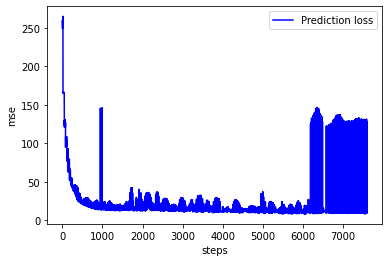

In [ ]:
predictor.plot_error()

# Not tested attempt with curiosity learning on Breakout

In [ ]:
!pip install baselines > /dev/null 2>&1
!pip install gym[atari,accept-rom-license]==0.21.0 > /dev/null 2>&1

In [ ]:
from collections import deque
import random

from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym

class QModel():
  def __init__(self,params):
    self.input_shape = params['input_shape']
    self.conv_layers = params['conv_layers']
    self.dense_layers = params['dense_layers']

  def get_model(self):
    self.model = keras.Sequential()

    self.model.add(layers.Input(self.input_shape))
    for conv_layer in self.conv_layers:
      self.model.add(layers.Conv2D(**conv_layer))
    self.model.add(layers.GlobalAveragePooling2D())
    for dense_layer in self.dense_layers:
      self.model.add(layers.Dense(**dense_layer))

    return self.model

class EnvMaker():
  def __init__(self):
    self.seed = 0

  def make_env(self):
    self.env = make_atari('BreakoutNoFrameskip-v4')
    self.env = wrap_deepmind(self.env, frame_stack=True, scale=True)
    self.env.seed(self.seed)
    return self.env

class Buffer():
  def __init__(self,params):
    self.max_len_buffer = params['max_len_buffer']
    self.buffer = deque([])

  def get_length_buffer(self):
    return len(self.buffer)

  def is_full(self):
    return self.get_length_buffer() >= self.max_len_buffer
  
  def check_length(self):
    if len(self.buffer) > self.max_len_buffer:
      self.buffer.popleft()

  def add_sample(self,sample):
    assert len(sample) == 5
    sample[0] = np.array(sample[0])
    sample[3] = np.array(sample[3])
    self.buffer.append(sample)
    self.check_length()

  def get_batch(self,batch_size):
    assert len(self.buffer) > batch_size, 'the buffer has {} elements, but at least {} are required'.format(len(self.buffer),batch_size)
    return random.sample(list(self.buffer), batch_size)

class DQNAgent():
  def __init__(self,params):
    self.model_train = params['model_train']
    self.model_target = params['model_target']
    self.epsilon_fn = params['epsilon_fn']
    self.epsilon_step = params['epsilon_step']
    self.optimizer = params['optimizer']
    self.loss = params['loss']
    self.env = params['env']
    self.buffer = params['buffer']
    self.batch_size = params['batch_size']
    self.gamma = params['gamma']
    self.num_actions = params['num_actions']
    self.epsilon = 1

  def random_collect(self,num_episodes, curiosity=False):
    total_reward = 0.0
    state = np.array(self.env.reset())
    for i in range(num_episodes):
      terminated = False
      while not terminated:
        random_action = random.randint(0,self.num_actions-1)
        state_next, reward, terminated, _ = self.env.step(random_action)

        self.buffer.add_sample([state,random_action,reward,state_next,terminated])
        total_reward += reward
        if terminated:
          state = np.array(self.env.reset())
        else:
          state = state_next
    return total_reward/num_episodes

  def get_action(self,state,mode='eps-greedy'):
    if random.uniform(0,1) <= self.epsilon and mode != 'greedy':
      action = random.randint(0,self.num_actions-1)
    else:
      qvalues = self.model_train.predict(self.parse_state(state),verbose=0)
      action = np.argmax(np.array(qvalues))
    return action

  def parse_state(self,state):
    state_tensor = tf.convert_to_tensor(np.array(state))
    return tf.expand_dims(state_tensor, 0)

  def get_target(self,ns,r,d):
    qtarget = self.model_target(ns)
    return (r+self.gamma*tf.reduce_max(qtarget,axis=-1))*(1-d)-d

  def train(self,reward_history,num_episode,iteration,curiosity=False):
    state = np.array(self.env.reset())
    terminated = False
    total_reward = 0.0
    self.epsilon = self.epsilon_fn(self.epsilon_step)

    trajectory = deque([state])

    while not terminated:
      action = self.get_action(state,'eps-greedy')
      state_next, reward, terminated, info = self.env.step(action)
      total_reward += reward

      trajectory.append(state_next)

      reward = self.update_reward(reward,state_next)

      self.buffer.add_sample([state,action,reward,state_next,terminated])

      if iteration % 4 == 0:
        batch = np.array(self.buffer.get_batch(self.batch_size))
        s,a,r,ns,d = [np.stack(batch[:,i]).astype(np.float32) for i in range(5)]

        qtarget = self.get_target(ns,r,d)

        with tf.GradientTape() as tape:
          qpredicted = self.model_train(s)
          masked_qpredicted = tf.reduce_sum(tf.multiply(qpredicted,tf.one_hot(a,self.num_actions)),axis=-1)
          loss = self.loss(masked_qpredicted,qtarget)

        gradients = tape.gradient(loss,self.model_train.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.model_train.trainable_variables))

      iteration += 1

      if iteration % 5000 == 0:
        self.epsilon_step.assign_add(1)

      if num_episode % 300 == 0:
        print("mean reward: {} --- episode: {} --- epsilon: {}".format(np.mean(reward_history),num_episode,self.epsilon))
        self.model_target.set_weights(self.model_train.get_weights())
        self.train_curiosity(trajectory)

      state = state_next

    return total_reward, iteration

  def train_curiosity(self,trajectory): #no curiosity
    pass

  def update_reward(self,reward,state_next): #reward not updated if curiosity is not used
    return reward

  def evaluate(self,num_episodes):
    total_reward = 0
    for i in range(num_episodes):
      state = self.env.reset()
      terminated = False
      while not terminated:
        action = self.get_action(state,'greedy')
        state_next, reward, terminated, _ = self.env.step(action)
        total_reward += reward
        state = state_next
    return float(total_reward)/float(num_episodes)

In [ ]:
## params

num_actions = 4

qmodel_params = {
    'input_shape': (84,84,4),
    'conv_layers': [
      {
        'filters': 32,
        'kernel_size': 3,
        'strides': 1,
        'activation': 'relu',
        'kernel_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),
        'bias_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)
      },
      {
        'filters': 64,
        'kernel_size': 3,
        'strides': 2,
        'activation': 'relu',
        'kernel_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),
        'bias_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)
      },
      {
        'filters': 128,
        'kernel_size': 3,
        'strides': 2,
        'activation': 'relu',
        'kernel_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),
        'bias_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)
      }
    ],
    'dense_layers': [
      {
        'units': 64,
        'activation': 'relu',
        'kernel_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),
        'bias_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)
      },
      {
        'units': num_actions,
        'activation': 'linear',
        'kernel_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),
        'bias_initializer': tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)
      }
    ]
}

buffer_params = {
    'max_len_buffer': 50000
}

dqnagent_params = {
    'model_train': QModel(qmodel_params).get_model(),
    'model_target': QModel(qmodel_params).get_model(),
    'epsilon_fn': keras.optimizers.schedules.PolynomialDecay(initial_learning_rate = 1.0, \
        decay_steps=50, end_learning_rate=0.01),
    'epsilon_step': tf.Variable(0),
    'optimizer': keras.optimizers.Adam(learning_rate=0.001),
    'loss': keras.losses.Huber(),
    'env': EnvMaker().make_env(),
    'buffer': Buffer(buffer_params),
    'batch_size': 32,
    'gamma': .99,
    'num_actions': num_actions,
}

agent = DQNAgent(dqnagent_params)

In [ ]:
QModel(qmodel_params).get_model().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 82, 82, 32)        1184      
                                                                 
 conv2d_33 (Conv2D)          (None, 40, 40, 64)        18496     
                                                                 
 conv2d_34 (Conv2D)          (None, 19, 19, 128)       73856     
                                                                 
 global_average_pooling2d_8   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                      

In [ ]:
eval_num_episodes = 5
target_reward = 1
random_collect_num_episodes = 50
collect_num_episodes = 1


def training_procedure(agent):
  iteration = 0
  reward_history = []
  collect_reward = agent.random_collect(random_collect_num_episodes)
  eval_reward = agent.evaluate(eval_num_episodes)
  print("Evaluating before training. Collect reward over {} episodes: {}".format(collect_reward,random_collect_num_episodes))

  reward_history.append(collect_reward)
  counter = 1 #for updating target network
  while eval_reward < target_reward:
    reward, iteration = agent.train(reward_history,counter,iteration)
    reward_history.append(reward)
    if len(reward_history) > 100:
      reward_history = reward_history[1:]
    counter+=1

In [ ]:
training_procedure(agent)

Evaluating before training. Collect reward over 0.22 episodes: 50


<ipython-input-13-dca5838e1d59>:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(self.buffer.get_batch(self.batch_size))


mean reward: 0.34 --- episode: 267 --- epsilon: 0.980199933052063
mean reward: 0.24 --- episode: 581 --- epsilon: 0.9405999779701233
mean reward: 0.28 --- episode: 894 --- epsilon: 0.9009999632835388
mean reward: 0.35 --- episode: 1185 --- epsilon: 0.8613999485969543
mean reward: 0.31 --- episode: 1474 --- epsilon: 0.8217999935150146
mean reward: 0.27 --- episode: 1762 --- epsilon: 0.7821999192237854
mean reward: 0.21 --- episode: 2063 --- epsilon: 0.7426000237464905
mean reward: 0.26 --- episode: 2369 --- epsilon: 0.7029999494552612
mean reward: 0.27 --- episode: 2674 --- epsilon: 0.6633999943733215
mean reward: 0.24 --- episode: 2960 --- epsilon: 0.6237999796867371
mean reward: 0.23 --- episode: 3256 --- epsilon: 0.5842000246047974
mean reward: 0.3 --- episode: 3552 --- epsilon: 0.5445999503135681
mean reward: 0.19 --- episode: 3856 --- epsilon: 0.5049999952316284
mean reward: 0.22 --- episode: 4168 --- epsilon: 0.46539998054504395
mean reward: 0.41 --- episode: 4454 --- epsilon: 0.4

KeyboardInterrupt: ignored

In [ ]:
training_procedure(agent)

Evaluating before training. Collect reward over 0.34 episodes: 50


<ipython-input-13-dca5838e1d59>:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(self.buffer.get_batch(self.batch_size))


mean reward: 0.92 --- episode: 164 --- epsilon: 0.009999999776482582
mean reward: 0.99 --- episode: 322 --- epsilon: 0.009999999776482582


KeyboardInterrupt: ignored

## Trying reachability networks...

In [ ]:
class TripletDistance(keras.layers.Layer):
  def __init__(self):
    super(TripletDistance,self).__init__()

  def call(self,anc,pos,neg):
    return tf.reduce_max(tf.square(anc-pos) - tf.square(anc-neg) + 1, 0)

class EmbeddingNetwork(keras.Model):
  def __init__(self):
    super(EmbeddingNetwork,self).__init__()
    self.sequential = keras.Sequential([
        keras.layers.Conv2D(8,3,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)),
        keras.layers.Conv2D(16,3,strides=2,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)),
        keras.layers.Conv2D(32,3,strides=2,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)),
        keras.layers.Conv2D(64,3,strides=2,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)),
        keras.layers.Conv2D(128,3,strides=2,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1),bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=.1)),
        keras.layers.GlobalAveragePooling2D()
    ])

  def call(self,input):
    return self.sequential(input)

In [ ]:
class MemoryBuffer(Buffer):
  def __init__(self,params):
    super(MemoryBuffer,self).__init__(params)
  
  def add_sample(self,sample):
    self.buffer.append(np.array(sample))
    self.check_length()

class DQNAgentCuriosity(DQNAgent):
  def __init__(self,params):
    super(DQNAgentCuriosity,self).__init__(params)
    self.embnet = params['embedding_network']
    self.memory_buffer = params['memory_buffer']

  def random_collect(self,num_episodes, curiosity=False):
    total_reward = 0.0
    state = np.array(self.env.reset())
    for i in range(num_episodes):
      terminated = False
      while not terminated:
        random_action = random.randint(0,self.num_actions-1)
        state_next, reward, terminated, _ = self.env.step(random_action)

        self.buffer.add_sample([state,random_action,reward,state_next,terminated])
        self.memory_buffer.add_sample(state_next)

        total_reward += reward
        if terminated:
          state = np.array(self.env.reset())
        else:
          state = state_next

    return total_reward/num_episodes

  def get_curiosity(self,observation):
    obs_embedding = self.embnet.predict(self.parse_state(observation),verbose=0)
    membuf_embedding = self.embnet.predict(tf.convert_to_tensor(np.array(self.memory_buffer.buffer)),verbose=0)

    mse = tf.keras.losses.MeanSquaredError()
    scores = []
    for el in membuf_embedding:
      #print(mse(obs_embedding,el))
      scores.append(mse(obs_embedding,el))

    score = tf.reduce_min(scores)

    return score

  def update_reward(self,reward,state_next):
    curiosity_score = self.get_curiosity(state_next)

    if curiosity_score > 1e-6 or not self.memory_buffer.is_full():
      self.memory_buffer.add_sample(state_next)

    return reward+curiosity_score

  def train_curiosity(self,trajectory):
    if len(trajectory) > 20:
      with tf.GradientTape() as tape:
        total_loss = 0.0

        state_idx = np.random.randint(len(trajectory))

        positive_state_idx = np.random.randint(max(state_idx-10,0),min(state_idx+10,len(trajectory)))
        
        minimum = state_idx-20 < 0
        maximum = state_idx+20 > len(trajectory)

        if minimum and maximum:
          return
        elif minimum and not maximum:
          negative_state_idx = np.random.randint(state_idx+20,len(trajectory))
        elif maximum and not minimum:
          negative_state_idx = np.random.randint(0,state_idx-20)
        else:
          neg1 = np.random.randint(state_idx+20,len(trajectory))
          neg2 = np.random.randint(0,state_idx-20)

          if np.random.randint(2):
            negative_state_idx = neg1
          else:
            negative_state_idx = neg2

        anc = self.embnet(np.expand_dims(trajectory[state_idx],axis=0))
        pos = self.embnet(np.expand_dims(trajectory[positive_state_idx],axis=0))
        neg = self.embnet(np.expand_dims(trajectory[negative_state_idx],axis=0))

        loss = self.embnet.loss(anc,pos,neg)
        total_loss += loss
      gradients = tape.gradient(total_loss,self.embnet.trainable_weights)
      self.embnet.optimizer.apply_gradients(zip(gradients,self.embnet.trainable_weights))

In [ ]:
memory_buffer_params = {
    'max_len_buffer': 5
}

embedding_model = EmbeddingNetwork()

compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-4),
    'loss': TripletDistance(),
}

embed_model = EmbeddingNetwork()
embed_model.compile(**compile_info)

dqnagent_params['embedding_network'] = embed_model
dqnagent_params['memory_buffer'] = MemoryBuffer(memory_buffer_params)

agent = DQNAgentCuriosity(dqnagent_params)

In [ ]:
training_procedure(agent)

## Testing learning with only intrinsic motivation

In [ ]:
class DQNAgentOnlyCuriosity(DQNAgentCuriosity):
  def __init__(self,params):
    super(DQNAgentOnlyCuriosity,self).__init__(params)
    self.embnet = params['embedding_network']
    self.memory_buffer = params['memory_buffer']

  def update_reward(self,reward,state_next):
    curiosity_score = self.get_curiosity(state_next)

    if curiosity_score > 1e-6 or not self.memory_buffer.is_full():
      self.memory_buffer.add_sample(state_next)

    return curiosity_score

In [ ]:
memory_buffer_params = {
    'max_len_buffer': 5
}

embedding_model = EmbeddingNetwork()

compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-4),
    'loss': TripletDistance(),
}

embed_model = EmbeddingNetwork()
embed_model.compile(**compile_info)

dqnagent_params['embedding_network'] = embed_model
dqnagent_params['memory_buffer'] = MemoryBuffer(memory_buffer_params)

agent = DQNAgentOnlyCuriosity(dqnagent_params)

In [ ]:
training_procedure(agent)

## What if there is no next state prediction but MSE?

In [ ]:
class DQNAgentMSECuriosity(DQNAgentCuriosity):
  def __init__(self,params):
    super(DQNAgentMSECuriosity,self).__init__(params)
    self.embnet = params['embedding_network']
    self.memory_buffer = params['memory_buffer']

  def update_reward(self,reward,state_next):
    curiosity_score = self.get_curiosity(state_next)

    if curiosity_score > 1e-6 or not self.memory_buffer.is_full():
      self.memory_buffer.add_sample(state_next)

    return curiosity_score

  def get_curiosity(self,state_next):
    mse = tf.keras.losses.MeanSquaredError()
    scores = []
    parsed_state_next = tf.convert_to_tensor(np.array(state_next))

    for el in self.memory_buffer.buffer:
      #print(mse(obs_embedding,el))
      scores.append(mse(parsed_state_next,tf.convert_to_tensor(np.array(el))))

    score = tf.reduce_min(scores)

    return score

  def train_curiosity(self,trajectory):
    pass

In [ ]:
memory_buffer_params = {
    'max_len_buffer': 5
}

embedding_model = EmbeddingNetwork()

compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-4),
    'loss': TripletDistance(),
}

embed_model = EmbeddingNetwork()
embed_model.compile(**compile_info)

dqnagent_params['embedding_network'] = embed_model
dqnagent_params['memory_buffer'] = MemoryBuffer(memory_buffer_params)

agent = DQNAgentMSECuriosity(dqnagent_params)

In [ ]:
training_procedure(agent)

Evaluating before training. Collect reward over 0.24 episodes: 50


<ipython-input-1-dca5838e1d59>:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(self.buffer.get_batch(self.batch_size))


mean reward: 1.42 --- episode: 125 --- epsilon: 0.009999999776482582
mean reward: 1.72 --- episode: 234 --- epsilon: 0.009999999776482582


KeyboardInterrupt: ignored